Why DIRECT? in this paper, the threats have been simplified to circular boundaries. In real life, the boundaries will be irregular, and will have no explicit differentiable expression avalible.

In [332]:
from scipy.optimize import direct, Bounds
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

s# Deriving the cost function.

## Finding an initial cost function

* Consider problem in two dimensions.
* Route consists of start and endpoints with a number of intermediate waypoints.
* The coordinates of the waypoints are the optimization variables.
* We want the distance flown to be minimal, so calculate Euclidian distance of the route, and label it $L$.
* Determine if any of our path lies within a threat, and the length of the path within the threat.

If the route lies within the $i$-th threat for a distance $L_i$ then the cost of the route can be expressed as

$C = L + \displaystyle\sum_{i} \rho _i L_{i}^{rho}$

$\rho _i$ is a penalty parameter for the $i$-th threat.

In other words, the cost is the total length of the path, plus the length of each segment within a threat multiplied by the penalty parameter associated with that particular threat.

## Defining "leg" length
We have $n$ waypoints $w_j = (w_{j1}, w_{j2})$ for $j = 1, ..., n$, let the start and end points be $w_0, w_{n+1}$ respectively. We can define the vector $u_j = w_j - w_{j-1}$ which helps us defined the length of any given leg as 

$l_j = \sqrt{(u_{j1}^2 + u_{j2}^2)}$

## Determining threat violations

We  will use linear interpoliation to estimate where leg $j$ intersects with threat $i$. 

Consider $\sigma _{max}$ to be the maximum step size for use in sampling any leg of a route. This means that the number of samplings points along leg $j$ is $K_{max} = \lceil l_j / \sigma _{max} \rceil$.Let the normalized step size be $\delta \lambda = \frac{1}{K_{max}}$ and let $u_k$ be a sampled point in the leg.

$u_k = w_{j-1} + k \delta \lambda (w_j - w_{j-1})$

$k = [0, ..., K_{max}]$.

Suppose we have an indicator function of position, $T_i$, such that $T_i(u_k) \leq 0$ indicates that the sampled position within the leg, $u_k$ is within threat i, and confirms that the position is not within the threat otherwise. Using what we have defined so far can create an algorithm for calculating "in threat" length, denoted $l_{ji}$.

1. Find $l_j$, $l_i$. Set $i_{ji} = 0$  
2. Set $k=0$, $K_{max}=(\delta \lambda)^{-1}$  
3. If $T_i (u_0) \leq 0$ then $\lambda _b = 0$  
4. For $k = 1, ..., K_{max}$   
5.  ---> If $T_i (u_k) \leq 0$ and $T_i (u_{k-1}) > 0$ then  
6.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _b = (k - \kappa)\delta \lambda$  
7.  ---> If $T_i (u_k) > 0$ and $T_i (u_{k-1}) \leq 0$ then  
8.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _e = (k - \kappa)\delta \lambda$  
9.  ------->  set $l_{ji} + (\lambda _e - \lambda _b) l_j$  
10.  ---> If $T_i (u_{K_{max}}) \leq 0$ then   
11.  -------> set $l_{ji} = l_{ji} + (1- \lambda _b )l_j$  

Line-by-line explanation:

1. Find the length of the current leg. Initialize "in threat" distance accumulator as 0.
2. Set up a counter at 0, and set $K_{max} = (\delta \lambda)^{-1}$. Recall: $\delta \lambda = 1/K_{max}$. So we're just initializing $K_{max}$ with it's own value.
3. Determine if our starting point is within the threat.
4. For k = 1 -> $K_{max}$ to start checking each point along the leg.
5. Detect if the path passed INTO the threat.
6. Calculate the location of the boundary with interpolation. $\kappa$ is the fractional interpolation value, it represents a number from 0-1 that says where the boundary crossing lies between two samples on the leg. After that, we calculate where the crossing occurs on the entire leg. We know the crossing occured when we took the k-th step. So $k-\kappa$ is the number of steps to where the boundary is, and $\delta \lambda$ is our step size.
7. Detect if the passed passed OUT of the threat
8. Perform the same interpolation as step 6. Set $\lambda _e$ instead which is the exit position.
9. Since we've exited, we can calculate the in-threat distance, $l_{ji}$. $(\lambda _e - \lambda _b)$ represents the normalized distance in the threat zone and multiplying it by $l_j$ converts it to real distance. Add it to the accumulator. 
10. Determine if exit point is inside the threat
11. Do a similar calculation to step 9, add it to the accumulator.
 
## Defining constraints
Two additional features are included to enhance the realism of the simulation. Firstly, you can restrict routes that involve sharp turns, and secondly, you can set a limit on the distance between waypoints.

The angle between successive legs is defined as $\phi _j$. Given by

$\phi _j = cos^{-1}\{\frac{u_j ^T u_{j+1}}{||u_j|| ||u_{j+1}||}\}$

$\phi _{max}$ is the limiting turn angle, and $l_{min}$ is the minimum leg-length. We can define a final extended cost function.

$$
C = \sum_{j=1}^{n+1} ( l_j + \mu (( l_{min} - l_j )_+ )^2 + \sum_{j=1}^m \rho _i l_{ji}^rho ) + \sum_{j=1}^n v ((\phi _j - \phi _{max})_+)^2
$$

$\mu$ and $v$ are positive penalty parameters for controling minimum leg length and turn angle.

Parameters for the cost function: $l_{min}, \phi _{max}, \mu, \nu$
Function will need list of waypoints, start and endpoint, and threat list.

In [ ]:
# Cost function
def cost(x, start, end, threats, lmin, phi_max, mu, nu, rho, sigma_max=4.0):
    waypoints = np.vstack([start, x.reshape(-1, 2), end])
    legs = np.diff(waypoints, axis=0)
    leg_lengths = np.linalg.norm(legs, axis=1)

    # Turn angles
    turn_angles = [
        np.arccos(np.clip(np.dot(legs[j-1], legs[j]) / 
                          (np.linalg.norm(legs[j-1]) * np.linalg.norm(legs[j])), -1, 1))
        for j in range(1, len(legs))
    ]

    # Calculate total cost
    total_cost = np.sum(leg_lengths) # Total path length
    total_cost += np.sum(mu * np.maximum(lmin - leg_lengths, 0) ** 2) # Leg length penalties
    total_cost += np.sum(nu * np.maximum(turn_angles - phi_max, 0) ** 2) # Turn angle penalties

    # Threat penalties
    for threat_centre, threat_radius in threats:
        l_ji = sum(
            in_threat_distance(waypoints[j], waypoints[j+1], threat_centre, threat_radius, sigma_max)
            for j in range(len(legs))
        )
        total_cost += rho * (l_ji ** 3)

    return total_cost

def T_i(point, center, radius):
    return np.linalg.norm(point - center) - radius

def in_threat_distance(start, end, center, radius, sigma_max):  # Center and radius are components of the threat.
    l_j = np.linalg.norm(end - start) # start and end are vectors.
    if l_j == 0:
        return 0 # Not sure
    l_ji = 0.0
    K_max = int(np.ceil(l_j / sigma_max))
    delta_lambda = 1 / K_max
    lambda_b = None

    # If starting inside threat zone
    if T_i(start, center, radius) <= 0:
        lambda_b = 0

    for k in range(1, K_max+1):
        lambda_k = k * delta_lambda
        u_k = start + lambda_k * (end - start)
        T_k = T_i(u_k, center, radius)

        u_k_prev = start + (lambda_k - delta_lambda) * (end - start)
        T_k_prev = T_i(u_k_prev, center, radius)

        # Entering threat zone
        if T_k <= 0 and T_k_prev > 0:
            kappa = T_k / (T_k - T_k_prev)
            lambda_b = (k - kappa) * delta_lambda
        
        # Exiting threat zone
        if T_k > 0 and T_k_prev <= 0:
            kappa = T_k / (T_k - T_k_prev)
            lambda_e = (k - kappa) * delta_lambda
            l_ji += (lambda_e - lambda_b) * l_j
            lambda_b = None
    
    # If ending inside threat zone
    if T_i(end, center, radius) <= 0 and lambda_b is not None:
        l_ji += (1.0 - lambda_b) * l_j
    
    return l_ji

def calculate_path_length(waypoints):
    legs = np.diff(waypoints, axis=0)
    return np.sum(np.linalg.norm(legs, axis=1))


In [334]:
threats = [ 
    (np.array([75,  29]),    9),    
    (np.array([80,  66]),    15),   
    (np.array([95,  115]),   22.5), 
    (np.array([135, 131]),   20),   
    (np.array([140, 67.5]),  37.5), 
    (np.array([197, 125]),   30)    
]

# Helper function to run DIRECT.
def optimize_leg(start, end, threats, initial_waypoints=None, initial_bounds=None, 
                n_waypoints=3, maxiter=128, nu=1, mu = 1, rho=3, restart=True, forced_waypoint=None):
    phi_max = np.radians(42.5)  
    lmin = 10
    
    # If initial_waypoints and initial_bounds are provided, use them
    if initial_waypoints is not None and initial_bounds is not None:
        initial_guess = initial_waypoints.flatten()
        lb = initial_bounds[:, 0].flatten()
        ub = initial_bounds[:, 1].flatten()
    else:
        # Default initial guess setup
        if forced_waypoint is None:
            midpoint = (start + end)/2
            initial_guess = np.tile(midpoint, n_waypoints)
            lb = initial_guess - np.array([60, 40]*n_waypoints)
            ub = initial_guess + np.array([60, 40]*n_waypoints)
        else:
            # Handle forced waypoint case
            initial_guess = []
            lb = []
            ub = []
            
            # The forced waypoint is at index 0 in this case
            fp_idx, fp_pos, fp_tol = forced_waypoint
            lb.extend(fp_pos - fp_tol)
            ub.extend(fp_pos + fp_tol)
            initial_guess.extend(fp_pos)
            
            # Add remaining waypoints
            for i in range(1, n_waypoints):
                # Position remaining waypoints between start and end with wide bounds
                pos = start + (i/(n_waypoints)) * (end - start)
                initial_guess.extend(pos)
                lb.extend(pos - np.array([100, 50]))
                ub.extend(pos + np.array([100, 50]))
            
            initial_guess = np.array(initial_guess)
            lb = np.array(lb)
            ub = np.array(ub)

    # First optimization run
    result = direct(lambda x: cost(x, start, end, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                   bounds=list(zip(lb, ub)),
                   maxfun=maxiter//2 if restart else maxiter,
                   locally_biased=True)
    
    if restart:
        # Refine the search around the best point found
        refined_lb = result.x - np.array([5, 5]*n_waypoints)
        refined_ub = result.x + np.array([5, 5]*n_waypoints)
        result = direct(lambda x: cost(x, start, end, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                       bounds=list(zip(refined_lb, refined_ub)),
                       maxfun=maxiter//2,
                       locally_biased=True)
    
    return result.x.reshape(-1, 2), result.fun

## Approach #1 - Separate calculation of outward and return legs.
First we're going to assume two waypoints will be sufficient. Place them at a point along the midline, paper uses (108 ± 60, 68 ± 40), (109 ± 60, 69 ± 40). Additionally we're using parameters µ = ν = ρ_i = 1.

In [335]:
origin = np.array([50, 30])
destination = np.array([167, 107])

# Initial "bad" guesses from the paper.
initial_waypoints = np.array([
    [108, 68],
    [109, 69]
])

initial_bounds = np.array([
    [[108 - 60, 108 + 60], [68 - 40, 68 + 40]],
    [[109 - 60, 109 + 60], [69 - 40, 69 + 40]]
]).transpose(0, 2, 1)

print("=== Optimizing Outbound Leg ===")
out_waypoints, out_cost = optimize_leg(
    origin, 
    destination, 
    threats, 
    initial_waypoints,
    initial_bounds,
    n_waypoints=2, 
    maxiter=64,
    nu=1, 
    mu=1, 
    rho=1,
    restart=True
)

outbound_path = np.vstack([origin, out_waypoints, destination])
outbound_length = calculate_path_length(outbound_path)
print(f"Outbound path length: {outbound_length:.2f} km")
print(f"Outbound cost: {out_cost:.2f}")  
print(f"\nOutbound waypoints:")
for i in out_waypoints:
    print(f"  {i}")


=== Optimizing Outbound Leg ===
Outbound path length: 159.94 km
Outbound cost: 32902.14

Outbound waypoints:
  [68.         82.44444444]
  [86.77777778 96.77777778]


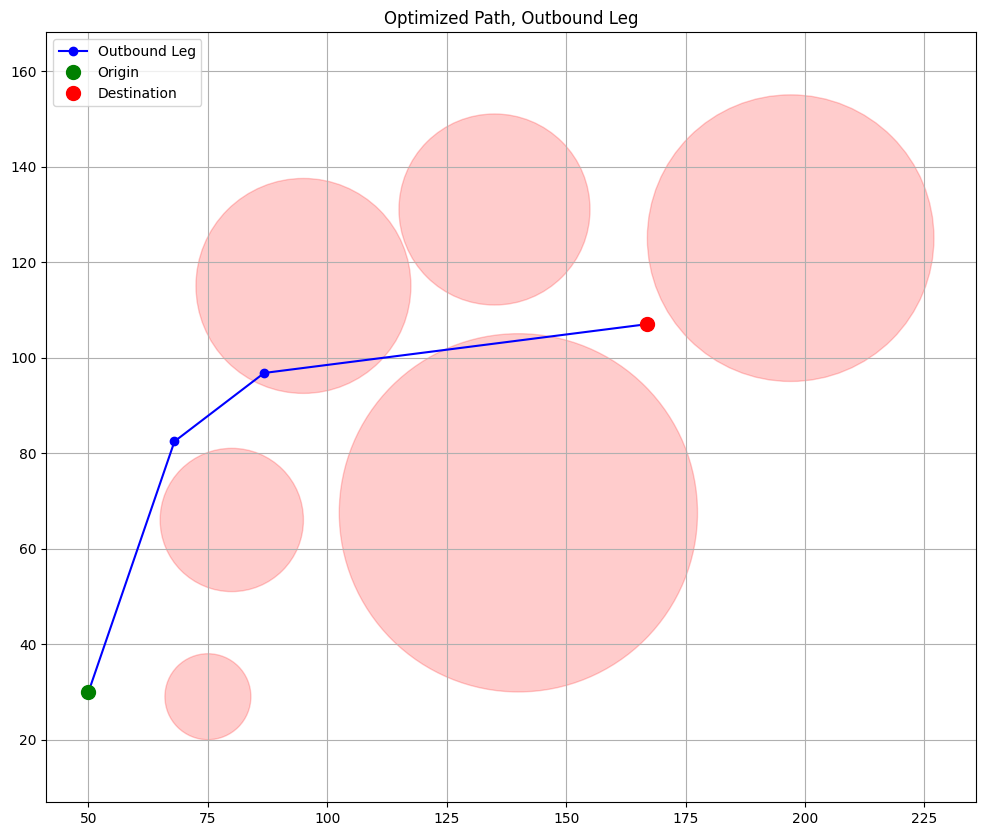

In [336]:
# Visualization for outbound leg
plt.figure(figsize=(12, 10))

# outbound leg
plt.plot(
    np.vstack([origin, out_waypoints, destination])[:, 0],
    np.vstack([origin, out_waypoints, destination])[:, 1],
    'b-o', 
    label='Outbound Leg'
)

plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin')
plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination')

for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))
plt.axis('equal')
plt.grid()
plt.legend()
plt.title("Optimized Path, Outbound Leg")
plt.show()
